# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from copy import deepcopy

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv

import attr
import pandas as pd
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import numpy as np

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.ml")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)
    
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container, get_lightning_artifact_ver
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

container = None

if container is not None:
    print("Deleting container")
    free_mem(container)
    
gc.collect()

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    if version == "latest":
        version = get_lightning_artifact_ver(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME)
        print(f"You are using LATEST ({version}) of '{LIGHTNING_CONTAINER_NAME}'")

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={
            "LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME,
            "VERSION": version
        }
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

# Lightning Module

In [ ]:
MINI_DATA = False  # True if used for testing purposes

attr.s(repr=False)
class CatBoostModule(LightningModule):
    """ Template for LightningModule """
        
    def on_configure(self) -> LightningConfig:
        
        # This datetime can be replaced with datetime.now()
        now = datetime(2021, 8, 20)

        opt_start = datetime(2021, 1, 1)
        opt_end = now - timedelta(days=60)
        
        # Lighting Configuration
        config = LightningConfig(
            
            # Basic info
            name        = "15n30-catboost_l1",
            timeframe   = "15m",
            exchange    = "binance",
            
            # Train and validation datetime
            trainval_start  = now - timedelta(days=365 * 5),
            trainval_end    = datetime(2021, 1, 1),
            
            # Backtest Optimization datetime
            opt_start = opt_start,
            opt_end   = opt_end,
            
            # Unbiased Backtest datetime
            test_start = opt_end + timedelta(days=1),
            test_end   = now,
            
            # Num training epochs
            num_training_epochs = 12000,
        )
        
        # Optional custom config attributes
        config.add_custom("num_future_candles", 2)
        config.add_custom("num_classification_classes", 5)
        config.add_custom("hardware", "GPU")
        config.add_custom("learning_rate", 0.02)
        
        return config
        
    def on_get_data_paths(self, cwd: Path, timeframe: str, exchange: str) -> List[Path]:
        """ Where your data is stored
        """
        path_data_exchange = cwd.parent / "mount" / "data" / exchange
        maximum_data = 999 if not MINI_DATA else 5
        
        return [
            datapath
            for datapath in list(path_data_exchange.glob(f"*-{timeframe}.json"))
            if datapath.name.split("-")[0].replace("_", "/")
            in PAIRS_HIGHCAP_NONSTABLE[:maximum_data]
        ]
    
    def on_add_features(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ On Add Features will be used in inference
        """
        # Start add features
        spaces = [3, 5, 9, 15, 25, 50, 100, 200]
        
        for i in spaces:
            df_onepair[f"ml_smadiff_{i}"] = (df_onepair['close'].rolling(i).mean() - df_onepair['close'])
            df_onepair[f"ml_maxdiff_{i}"] = (df_onepair['close'].rolling(i).max() - df_onepair['close'])
            df_onepair[f"ml_mindiff_{i}"] = (df_onepair['close'].rolling(i).min() - df_onepair['close'])
            df_onepair[f"ml_std_{i}"] = df_onepair['close'].rolling(i).std()
            df_onepair[f"ml_ma_{i}"] = df_onepair['close'].pct_change(i).rolling(i).mean()
            # Volume
            df_onepair[f"ml_volmaxdiff_{i}"] = (df_onepair['volume'].rolling(i).max() - df_onepair['volume'])
            df_onepair[f"ml_volmindiff_{i}"] = (df_onepair['volume'].rolling(i).min() - df_onepair['volume'])
            df_onepair[f"ml_volsmadiff_{i}"] = (df_onepair['volume'].rolling(i).mean() - df_onepair['volume'])
            df_onepair[f"ml_volstd_{i}"] = df_onepair['volume'].rolling(i).std()
            df_onepair[f"ml_volma_{i}"] = df_onepair['volume'].pct_change(i).rolling(i).mean()

        previous_prices = 15
        for i in range(previous_prices):
            df_onepair[f"ml_prevclose_{i}"] = (df_onepair["close"].shift(i) - df_onepair["close"]) / df_onepair["close"]
            
        df_onepair["ml_volume_pctchange"] = df_onepair['volume'].pct_change()
        df_onepair['ml_z_score_120'] = ((df_onepair["ml_ma_15"] - df_onepair["ml_ma_15"].rolling(21).mean() + 1e-9) 
                             / (df_onepair["ml_ma_15"].rolling(21).std() + 1e-9))
        
        return df_onepair
    
    def on_add_labels(self, df_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Define the labels
        """
        future_price = df_onepair['close'].shift(-self.config.num_future_candles)
        ml_label = (future_price - df_onepair['close']) / df_onepair['close']
        df_onepair[self.config.column_y] = pd.qcut(ml_label, self.config.num_classification_classes, labels=False)
        return df_onepair
    
    def on_final_processing(self, df_allpairs: pd.DataFrame) -> Tuple[Any, Any, Any, Any]:
        """ Define the data to X_train, X_val, y_train, y_val
        """
        val_split_date = pd.to_datetime(self.config.trainval_end - timedelta(days=60), utc=True, infer_datetime_format=True)
        
        train = df_allpairs[df_allpairs["date"] < val_split_date]
        val = df_allpairs[df_allpairs["date"] >= val_split_date]
        
        X_train = train[self.config.columns_x]
        X_val = val[self.config.columns_x]
        y_train = train[self.config.column_y]
        y_val = val[self.config.column_y]
    
        print("Num train datas:", len(train))
        print("Num val datas:", len(val))

        return X_train, X_val, y_train, y_val
    
    def on_define_model(self, run: Run, X_train, X_val, y_train, y_val) -> Any:
        """ Define your model!
        """
        return CatBoostClassifier(
            custom_loss=[metrics.Accuracy()],
            iterations=self.config.num_training_epochs, 
            task_type=self.config.hardware,
            learning_rate=self.config.learning_rate,
         )
    
    def on_start_training(self, run: Run, X_train, X_val, y_train, y_val):
        """ Training / model fit code
        """
        print("Start Training...")
        self.model: CatBoostClassifier
        self.model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            plot=True,
            verbose=250,
        )
        print("Accuracy: %.2f" % self.model.score(X_val, y_val))
    
    def on_predict(self, df_input_onepair: pd.DataFrame) -> pd.DataFrame:
        """ Inference, used in freqtrade
        """
        df_input_np = df_input_onepair.to_numpy()
        preds = self.model.predict_proba(df_input_np)
        df_preds = pd.DataFrame(preds)
        return df_preds
    
    def on_training_step(self, run: Run, data: dict):
        raise NotImplementedError()


module = CatBoostModule()

# Dataset EDA Before Training

In [ ]:
df_: pd.DataFrame = lightning_utils.get_dataset_df(module)
dates = df_["date"]
df_ = df_[module.config.columns_x + [module.config.column_y]]
df_.tail()

In [ ]:
def dataframe_statistics(df_: pd.DataFrame):
    # Detect nan, infinity, and too large values in dataset
    print("N rows na:", str(df_.shape[0] - df_.dropna().shape[0]))
    print("N rows inf:", str(df_.shape[0] - df_.replace([np.inf, -np.inf], np.nan).dropna().shape[0]))
    print("Cols na:", str(df_.columns[df_.isna().any()].tolist()))
    print("Cols inf:", str(list(df_.columns.to_series()[np.isinf(df_).any()])))

    # Detect columns with irregular datatypes
    supported_datatypes = ["float32"]
    print("Irregular (col, dtypes):", str([(it, df_[it].dtype) for it in df_.columns if df_[it].dtype not in supported_datatypes]))

    # Dataset statistics
    print("Dataset Length: %s" % len(df_))
    print("Date Min: %s" % dates.min())
    print("Date Max: %s" % dates.max())
    
dataframe_statistics(df_)

In [ ]:
df_["ml_label"].hist()

In [ ]:
df_.info()

In [ ]:
# Unload dataset after EDA to save memory
free_mem(df_)

# [-Start Training-]

In [ ]:
with wandb.init(project=module.config.name) as run:
    trainer = TradingTrainer()
    container = trainer.fit(module, run, True)

# Predictions EDA

In [ ]:
# Validate prediction function by simulate inserting freqtrade data into predict function
df_val_preds = trainer.validate_predict(container)
df_val_preds

In [ ]:
def plot_feature_importance(importance,names,model_type):
    import matplotlib.pyplot as plt
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    plt.barh(width=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(container.module.model.get_feature_importance(), container.config.columns_x, 'CATBOOST')

# Backtesting: Model Validation (Must Profitable)

Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

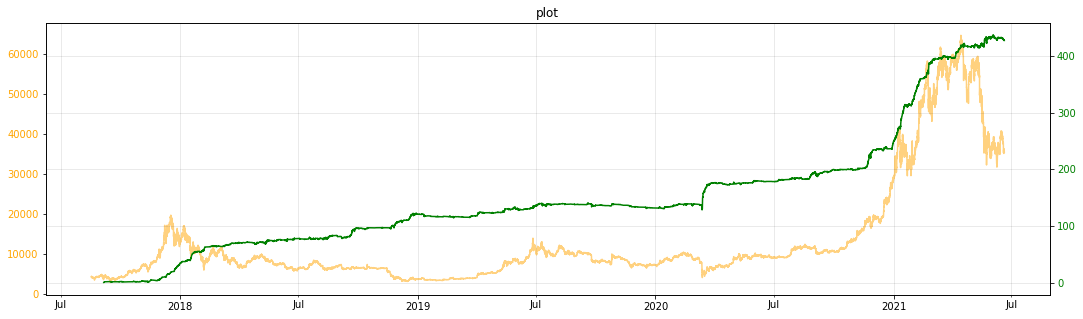

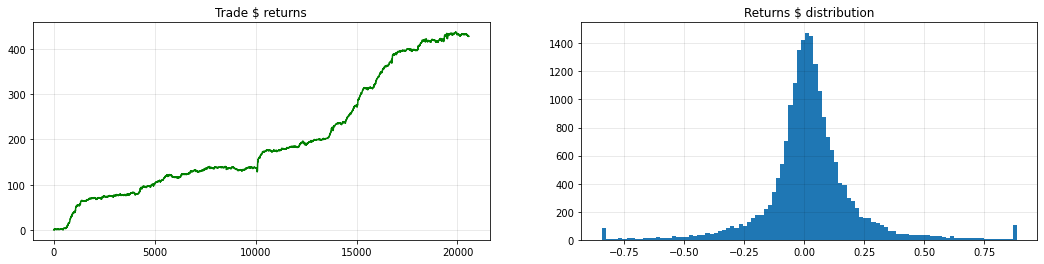

,Portfolio Summary
Trades,20567
Avg. Stake Amount,15.0
Number of Pairs,4
Min Balance,0.15
Max Balance,436.59
Final Balance,427.54
-,-
Wins,11636
Loses,8931
Win Rate,56.58%


In [18]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.

TIP: High threshold no trendline |OR| Low threshold with trendline
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)

    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -999
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe = lightning_container.predict(dataframe)
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1

            return dataframe
    """ End Strategy Code """

MODEL_NAME = "15n30-catboost_l1"
MODEL_VER = "v2"

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Backtesting: Strategy Optimization

Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

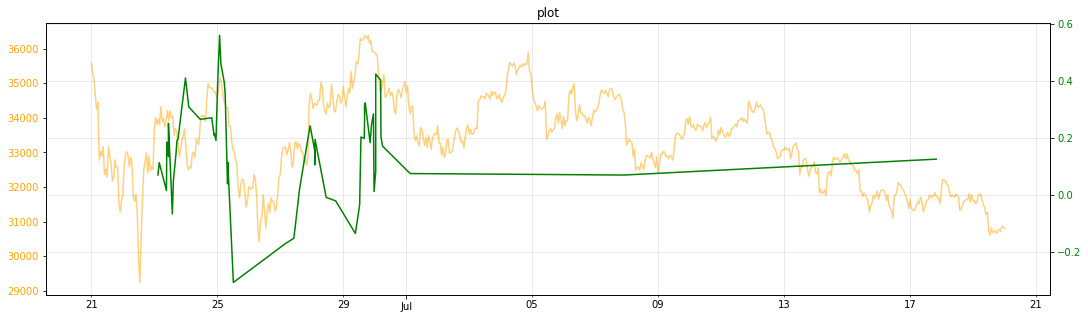

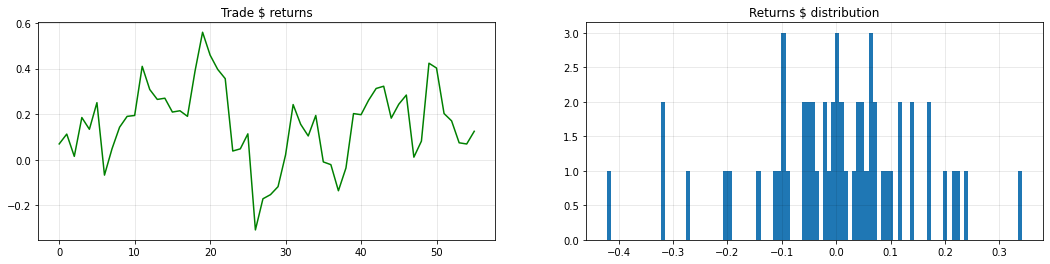

,Portfolio Summary
Trades,56
Avg. Stake Amount,15.0
Number of Pairs,4
Min Balance,-0.31
Max Balance,0.56
Final Balance,0.13
-,-
Wins,31
Loses,25
Win Rate,55.36%


In [26]:
"""
Phase where you can trial and error, plug and play model with any strategy, until get the best results.
In this phase, feel free to combine the trained model with a variety of technical indicators or ensemble with another model.
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="[|VERSION|]")        
    tp = str(int(lightning_container.config.timeframe.replace("m", "")) * lightning_container.config.num_future_candles)
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {tp: -1}
        stoploss = -0.99
        startup_candle_count: int = 500
        
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema"] = ta.EMA(dataframe, timeperiod=200)
            dataframe = lightning_container.predict(dataframe)
            
            num_classes = lightning_container.config.num_classification_classes
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe['close'] > dataframe['ema'],
                dataframe['argmax_ml'] == "ml_4",
                dataframe['ml_4'] > 0.4,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """

stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Backtesting: Final Phase

Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

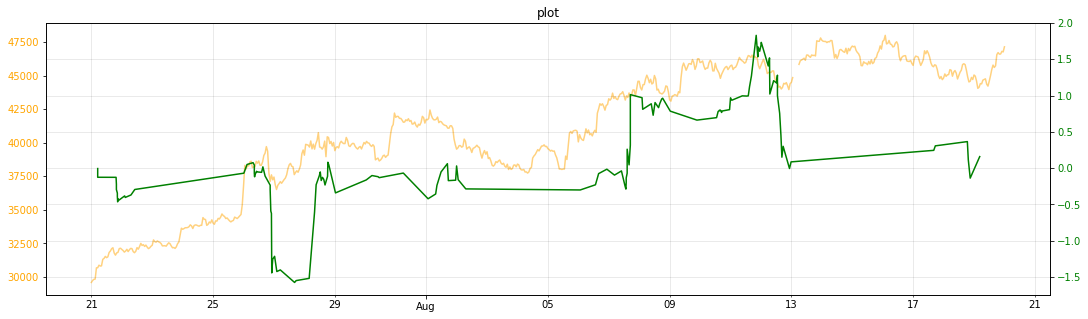

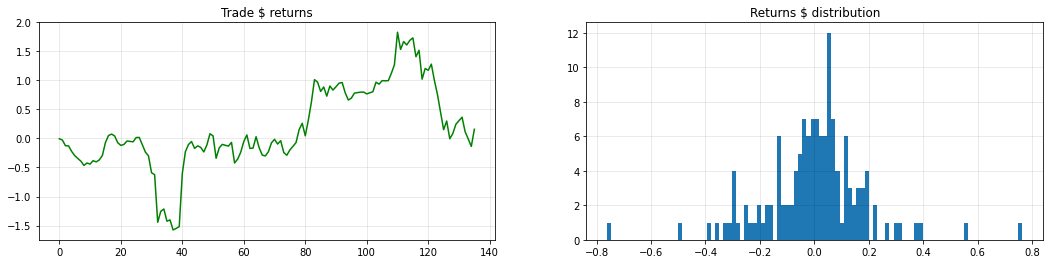

,Portfolio Summary
Trades,136
Avg. Stake Amount,15.0
Number of Pairs,4
Min Balance,-1.58
Max Balance,1.83
Final Balance,0.16
-,-
Wins,74
Loses,62
Win Rate,54.41%


In [27]:
"""
This is a phase where you believe your strategy is now optimized with your model.
This is not trial and error phase, and you can only run this phase ONCE every "good" optimized strategy to avoid biased results.
"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)